In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lzma
import upsetplot as up
import glob
import os
from tqdm import tqdm
import json
import seaborn as sns
import pyranges as pr
import matplotlib as mpl


'Artery_Tibial.ENSG00000290476.2,Astle_et_al_2016_Lymphocyte_counts-:-cos1:y9_y20-:-Artery_Tibial-:-chr13:39514719-40976519-:-trait_shared-:-all_genes'


* this is a microrna host gene
Gene: ENSG00000290476.2 | Chr: chr13 | Start: 40798367 | End: 40921891Overlaps miRNA: ENSG00000207652.1 | Chr: chr13 | Start: 40810765 | End: 40810861


In [ ]:
gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")

KeyboardInterrupt: 

In [ ]:
full_gencode_v47_path = "/home/klawren/oak/gtex/data/other_references/gencode/gencode.v47.annotation.gtf"
gencode_v47=pr.read_gtf(full_gencode_v47_path).as_df()

In [ ]:
gencode_v39 = pr.read_gtf("/home/klawren/oak/gtex/data/other_references/gencode/gencode.v39.annotation.gtf").as_df()


In [ ]:
gencode_v39[gencode_v39['gene_id'].str.contains('ENSG00000207652')]

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
2091773,chr13,ENSEMBL,gene,40810765,40810861,.,+,.,ENSG00000207652.1,miRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2091774,chr13,ENSEMBL,transcript,40810765,40810861,.,+,.,ENSG00000207652.1,miRNA,...,miRNA,MIR621-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
2091775,chr13,ENSEMBL,exon,40810765,40810861,.,+,.,ENSG00000207652.1,miRNA,...,miRNA,MIR621-201,NA,Ensembl_canonical,NaN,1,ENSE00001499926.1,NaN,NaN,NaN


In [ ]:
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)
tissue_color_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

# Load in tissue sample sizes and add tissue_file_name to num_samples
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE'] == 'RNASEQ']
num_samples = pd.DataFrame(passed_samples.groupby('SMTSD').size()).rename(columns={0: 'num_samples'}).reset_index()

# Merge to get tissue_file_name into num_samples
num_samples = pd.merge(
    num_samples,
    tissue_df,
    left_on='SMTSD',
    right_on='tissue_name',
    how='left'
)

qtl_tissue_df = num_samples[num_samples['num_samples'] > 30]


gene_type_pal_highlight = {'new_lncRNA':'#fb83ba',
                            'existing_lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}

gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey



/local/scratch/klawren/slrmtmp.48923679/ipykernel_9277/4008380624.py:18: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


In [ ]:
qtl_tissue_df = qtl_tissue_df[qtl_tissue_df['tissue_file_name'] == 'Artery_Tibial']

In [ ]:
# def load_gwas_df(files):
#     dfs = []
#     # Load all files into a single DataFrame, keeping the filename as a column
#     for f in tqdm(files):
#         df = pd.read_csv(f, sep='\t')
#         df['source_file'] = os.path.basename(f)
#         dfs.append(df)
#     print('Found', len(dfs), 'gwas files')
#     gwas_df = pd.concat(dfs, ignore_index=True)
#     gwas_df['tissue_id'] = gwas_df['source_file'].str.split('.').str[0]
#     gwas_df['ld_block'] = gwas_df['source_file'].str.split('.').str[1]
#     print('Found', gwas_df['source_file'].nunique(), 'unique gwas files')
#     print('Found', gwas_df['ld_block'].nunique(), 'unique ld blocks')
#     print('Found', gwas_df['tissue_id'].nunique(), 'unique tissues')
#     return gwas_df


# # split the robust results that somehow still have cos_npc < 0.5
# # filter split with original_npc_outcome > .2
# def split_robust_results(robust_gwas_df, gwas_df, cos_threshold=0.5, npc_threshold=0.75):
#     low_cos = robust_gwas_df[(robust_gwas_df['cos_npc'] < cos_threshold) & (robust_gwas_df['cs_type'] == 'trait_shared')]
#     print('Found', len(low_cos), 'robust results with cos_npc <', cos_threshold)
#     low_cos['cs_type'] = 'trait_specific_from_shared'
#     low_cos['converted_from_shared'] = True
#     low_cos['original_cos_npc'] = low_cos['cos_npc']
#     low_cos['cos_npc'] = np.nan
#     low_cos['phenotype_id'] = low_cos['phenotype_id'].str.split(',')
#     low_cos['neg_log10_p_value'] = low_cos['neg_log10_p_value'].str.split(', ')
#     low_cos['original_npc_outcome'] = low_cos['npc_outcome'].str.split(', ')
#     low_cos['npc_outcome'] = np.nan
#     low_cos['original_cos_id'] = low_cos['cs_id']
#     low_cos['cs_id'] = low_cos['cs_id'].str.split(':').str[1].str.split('_')
#     low_cos = low_cos.explode(['phenotype_id', 'original_npc_outcome', 'neg_log10_p_value', 'cs_id'])
#     low_cos['cs_id'] = 'ucos_new:' + low_cos['cs_id']

#     # get the previously split robust results annotated
#     gwas_df['individual_phenotype_id'] = gwas_df['phenotype_id'].str.split(',')
#     gwas_df['original_npc_outcome'] = gwas_df['npc_outcome'].str.split(', ')
#     all_joint_exploded = gwas_df.explode(['individual_phenotype_id', 'original_npc_outcome'])
#     trait_specific_from_shared = robust_gwas_df[robust_gwas_df['cs_type'] == 'trait_specific_from_shared'].drop(columns=['original_npc_outcome'])
#     trait_specific_from_shared = pd.merge(
#         trait_specific_from_shared,
#         all_joint_exploded[['individual_phenotype_id', 'tissue_id', 'ld_block', 'cs_id', 'original_npc_outcome']],
#         left_on=['phenotype_id', 'tissue_id', 'ld_block', 'original_cos_id'],
#         right_on=['individual_phenotype_id', 'tissue_id', 'ld_block', 'cs_id'],
#         how='left'
#     )

#     split_robust_results = pd.concat([trait_specific_from_shared, low_cos])

#     # keep those with original_npc_outcome > .2
#     print('Found', len(split_robust_results), 'robust results')
#     split_robust_results = split_robust_results[split_robust_results['original_npc_outcome'].astype(float) > npc_threshold]
#     print('Found', len(split_robust_results), f'robust results with original_npc_outcome > {npc_threshold}')

#     return pd.concat([split_robust_results,  robust_gwas_df[(robust_gwas_df['cos_npc'] > cos_threshold) & (robust_gwas_df['cs_type']!='trait_specific_from_shared')]])

# all_files = glob.glob('/home/klawren/oak/gtex/output/coloc/single_tissue_gwas_strong_only/**/*all_genes.colocboost.separate_gwas.*.txt', recursive=True)
# all_joint_gwas_df = load_gwas_df(all_files)
# robust_files = glob.glob('/home/klawren/oak/gtex/output/coloc/single_tissue_gwas_strong_only/**/*all_genes.colocboost.separate_gwas.*.robust.txt', recursive=True)
# robust_all_joint_gwas_df = load_gwas_df(robust_files)
# robust_all_joint_gwas_df = split_robust_results(robust_all_joint_gwas_df, all_joint_gwas_df)

In [ ]:
def get_per_tissue_coloc_dfs(tissue_ids, coloc_output_dir, coloc_type, file_name, robust=True):
    all_coloc_dfs = []
    for tissue_id in tqdm(tissue_ids):
        if robust:
            file_path = f"{coloc_output_dir}/{tissue_id}.{coloc_type}.{file_name}.robust.txt"
        else:
            file_path = f"{coloc_output_dir}/{tissue_id}.{coloc_type}.{file_name}.txt"
        try:
            df = pd.read_table(file_path)
            df['tissue_id'] = tissue_id
            df['ld_block'] = df['source_file'].str.split('/').str[-1].str.split('.').str[1]
            all_coloc_dfs.append(df)
        except FileNotFoundError:
            print(f"File not found for tissue_id: {tissue_id}")
    return pd.concat(all_coloc_dfs)

In [ ]:
coloc_dir = "/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_gwas_strong_only"

In [ ]:
all_coloc_robust_dfs = get_per_tissue_coloc_dfs(qtl_tissue_df['tissue_file_name'].unique(), coloc_dir, coloc_type="separate_gwas", file_name="all", robust=True)
all_coloc_robust_dfs['unique_cos_id'] = all_coloc_robust_dfs['phenotype_id'] + '-:-' + all_coloc_robust_dfs['cs_id'] + '-:-' + all_coloc_robust_dfs['tissue_id'] + '-:-' + all_coloc_robust_dfs['ld_block'] + '-:-' + all_coloc_robust_dfs['cs_type'] + '-:-' + 'all_genes'
all_coloc_robust_dfs['individual_phenotype_id'] = all_coloc_robust_dfs['phenotype_id'].str.split(',')
all_coloc_robust_dfs['individual_pvalue'] = all_coloc_robust_dfs['neg_log10_p_value'].str.split(', ')

  0%|                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


In [ ]:
# get to just lead variants
joint_gwas_lead_vars = (
    all_coloc_robust_dfs
    .sort_values('pip', ascending=False)
    .groupby(['phenotype_id', 'cs_id', 'tissue_id', 'ld_block'], as_index=False)
    .first()
)

# After selecting lead variants, also get their neg_log10_p_value:
# This column will simply be preserved via .first(), but ensure it's present and not overwritten later.
joint_gwas_lead_vars['neg_log10_p_value'] = (
    all_coloc_robust_dfs
    .sort_values('pip', ascending=False)
    .groupby(['phenotype_id', 'cs_id', 'tissue_id', 'ld_block'])['neg_log10_p_value']
    .first()
    .values
)
print('Found', len(joint_gwas_lead_vars), 'loci')


Found 24230 loci


In [ ]:
# explode out to individual gene parts of phentoye to annotated with gene type
joint_gwas_lead_vars['individual_phenotype_id'] = joint_gwas_lead_vars['phenotype_id'].str.split(',')
joint_gwas_exploded = joint_gwas_lead_vars.explode('individual_phenotype_id')
joint_gwas_exploded['gene_id'] = np.where(joint_gwas_exploded['individual_phenotype_id'].str.contains('ENSG'), 
                                          joint_gwas_exploded['individual_phenotype_id'].str.split('.').str[1], 
                                          'GWAS')

# merge with gencode ids to get gene type
joint_gwas_exploded = pd.merge(joint_gwas_exploded, gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], left_on='gene_id', right_on='gene_id_stable', how='left')
joint_gwas_exploded['gene_type_grouped_highlight'].value_counts()

gene_type_grouped_highlight
protein_coding     10702
existing_lncRNA     4109
new_lncRNA          1885
pseudogene           650
sRNA                  69
Name: count, dtype: int64

In [ ]:
joint_gwas_exploded['individual_phenotype_id'].value_counts()

individual_phenotype_id
UKB_50_Standing_height              1901
UKB_21001_Body_mass_index_BMI       1131
GIANT_HEIGHT                        1129
UKB_23099_Body_fat_percentage        798
Astle_et_al_2016_Platelet_count      477
                                    ... 
Artery_Tibial.ENSG00000110060.9        1
Artery_Tibial.ENSG00000109929.10       1
Artery_Tibial.ENSG00000111639.8        1
Artery_Tibial.ENSG00000111247.15       1
Artery_Tibial.ENSG00000110675.13       1
Name: count, Length: 5274, dtype: int64

In [ ]:
# group back into sets

# First, add a column to indicate if the individual_phenotype_id is 'gwas'
joint_gwas_exploded['is_gwas'] = ~joint_gwas_exploded['individual_phenotype_id'].str.contains('ENSG')

joint_gwas_lead_var_annotated = joint_gwas_exploded.groupby(
    ['phenotype_id', 'cs_id', 'tissue_id', 'ld_block'], as_index=False
).agg({
    'gene_type_grouped_highlight': lambda x: [v for v in x if pd.notna(v)],
    'variant_id': 'first',
    'cos_npc': 'first',
    'neg_log10_p_value': 'first',
    'is_gwas': 'sum',  # This will count the number of 'gwas' entries per group
})

# Rename 'is_gwas' to 'num_gwas' for clarity
joint_gwas_lead_var_annotated = joint_gwas_lead_var_annotated.rename(columns={'is_gwas': 'num_gwas'})

print(f'Annotated {len(joint_gwas_lead_var_annotated)} loci (should be {len(joint_gwas_lead_vars)})')

Annotated 24230 loci (should be 24230)


/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth

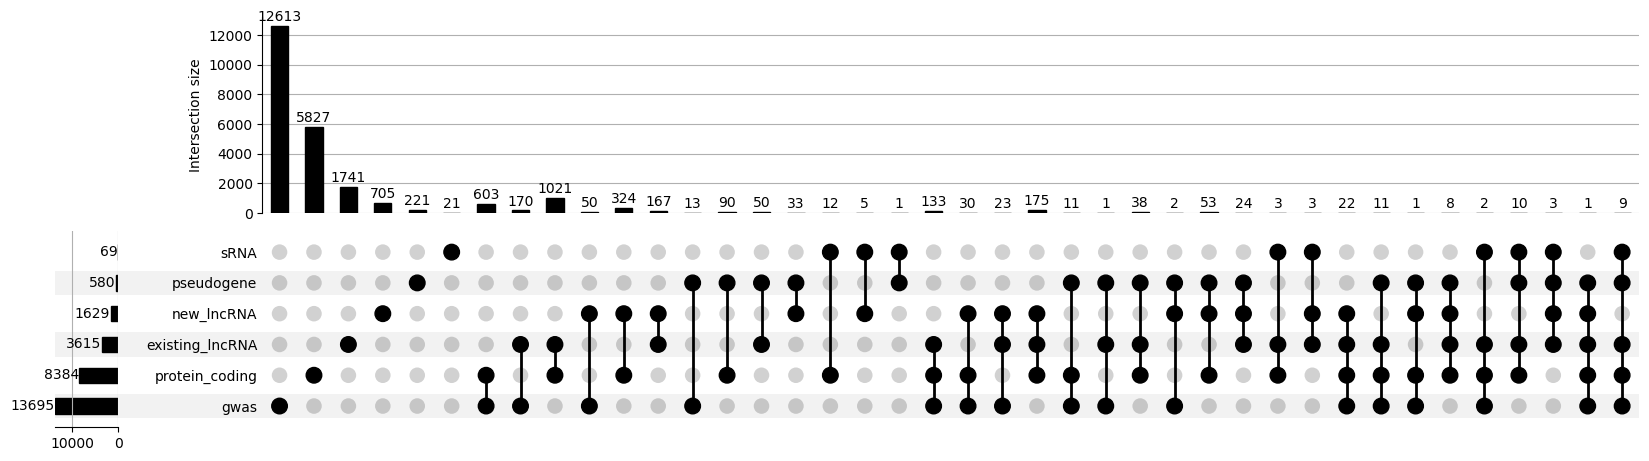

In [ ]:
joint_gwas_lead_var_annotated['phenotype_types'] = np.where(joint_gwas_lead_var_annotated['num_gwas'] > 0, joint_gwas_lead_var_annotated['gene_type_grouped_highlight'].apply(lambda x: x + ['gwas']), joint_gwas_lead_var_annotated['gene_type_grouped_highlight'])
upset_data = up.from_memberships(joint_gwas_lead_var_annotated['phenotype_types'])
upset_data = upset_data.groupby(level=list(range(upset_data.index.nlevels))).size()

up.plot(upset_data, show_counts=True)
plt.show()

In [ ]:
new_lncrna_loci = joint_gwas_lead_var_annotated[
    joint_gwas_lead_var_annotated['gene_type_grouped_highlight'].apply(
        lambda x: isinstance(x, list) and x == ['new_lncRNA']
    )
]
print(f'Found {len(new_lncrna_loci)} new lncRNA specific loci')
new_lncrna_loci_with_gwas = new_lncrna_loci[new_lncrna_loci['num_gwas'] > 0]
print(f'Found {len(new_lncrna_loci_with_gwas)} new lncRNA specific loci with at least one GWAS signal')
new_lncrna_loci_with_gwas



Found 713 new lncRNA specific loci
Found 48 new lncRNA specific loci with at least one GWAS signal


,phenotype_id,cs_id,tissue_id,ld_block,gene_type_grouped_highlight,variant_id,cos_npc,neg_log10_p_value,num_gwas,phenotype_types
10500,"Artery_Tibial.ENSG00000290021.1,UKB_20002_1111...",cos1:y4_y16,Artery_Tibial,chr3:188486545-189336989,[new_lncRNA],chr3:188626358:T:C:b38,0.5752,"3.75374, 1.17587",1,"[new_lncRNA, gwas]"
10501,"Artery_Tibial.ENSG00000290021.1,UKB_6152_9_dia...",cos2:y4_y16,Artery_Tibial,chr3:188486545-189336989,[new_lncRNA],chr3:188613583:T:A:b38,0.5329,"4.25251, 2.70403",1,"[new_lncRNA, gwas]"
10510,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...",cos1:y9_y20,Artery_Tibial,chr13:39514719-40976519,[new_lncRNA],chr13:40844990:T:C:b38,0.8747,"61.2693, 7.68656",1,"[new_lncRNA, gwas]"
10592,"Artery_Tibial.ENSG00000290862.2,GIANT_HEIGHT",cos4:y37_y57,Artery_Tibial,chr3:184395718-186204235,[new_lncRNA],chr3:185957819:G:A:b38,0.6881,"6.08919, 6.09355",1,"[new_lncRNA, gwas]"
10626,"Artery_Tibial.ENSG00000290957.2,UKB_20127_Neur...",cos1:y6_y14,Artery_Tibial,chr11:15724847-16821828,[new_lncRNA],chr11:16381008:T:TA:b38,0.9506,"3.10886, 1.00739",1,"[new_lncRNA, gwas]"
10791,"Artery_Tibial.ENSG00000293372.2,Astle_et_al_20...",cos6:y6_y17,Artery_Tibial,chr8:8879955-9819706,[new_lncRNA],chr8:8941601:C:A:b38,0.9382,"15.3702, 7.09372",1,"[new_lncRNA, gwas]"
10792,"Artery_Tibial.ENSG00000293372.2,Astle_et_al_20...",cos6:y6_y17,Artery_Tibial,chr8:8879955-9819706,[new_lncRNA],chr8:8967348:T:G:b38,0.8082,"19.3279, 3.35576",1,"[new_lncRNA, gwas]"
10793,"Artery_Tibial.ENSG00000293372.2,Astle_et_al_20...",cos5:y6_y17,Artery_Tibial,chr8:8879955-9819706,[new_lncRNA],chr8:8940712:A:T:b38,0.8630,"17.18, 6.17574",1,"[new_lncRNA, gwas]"
10794,"Artery_Tibial.ENSG00000293372.2,UKB_1180_Morni...",cos3:y6_y17,Artery_Tibial,chr8:8879955-9819706,[new_lncRNA],chr8:8967348:T:G:b38,0.8093,"19.3279, 2.28317",1,"[new_lncRNA, gwas]"
10822,"Artery_Tibial.ENSG00000293488.2,Astle_et_al_20...",cos3:y41_y62,Artery_Tibial,chr12:8604886-9849404,[new_lncRNA],chr12:9732486:G:A:b38,0.9955,"20.1311, 50.0558",1,"[new_lncRNA, gwas]"


In [ ]:
# Keep only rows where all neg_log10_p_value split values are > 6
new_lncrna_loci_with_gwas['neg_log10_p_value_split'] = new_lncrna_loci_with_gwas['neg_log10_p_value'].str.split(', ')
# Convert to float and filter
mask = new_lncrna_loci_with_gwas['neg_log10_p_value_split'].apply(
    lambda values: all(float(v) > 6 for v in values)
)
strong_new_lncrna_loci_with_gwas = new_lncrna_loci_with_gwas[mask]
print(strong_new_lncrna_loci_with_gwas['phenotype_id'].values)
strong_new_lncrna_loci_with_gwas

['Artery_Tibial.ENSG00000290476.2,Astle_et_al_2016_Lymphocyte_counts'
 'Artery_Tibial.ENSG00000290862.2,GIANT_HEIGHT'
 'Artery_Tibial.ENSG00000293372.2,Astle_et_al_2016_Granulocyte_count'
 'Artery_Tibial.ENSG00000293372.2,Astle_et_al_2016_Sum_basophil_neutrophil_counts'
 'Artery_Tibial.ENSG00000293488.2,Astle_et_al_2016_Lymphocyte_counts'
 'Artery_Tibial.ENSG00000293664.1,Astle_et_al_2016_Reticulocyte_count'
 'Artery_Tibial.ENSG00000296873.1,GIANT_2015_BMI_EUR'
 'Artery_Tibial.ENSG00000296873.1,UKB_21001_Body_mass_index_BMI'
 'Artery_Tibial.ENSG00000309532.1,GIANT_HEIGHT']


/local/scratch/klawren/slrmtmp.48923679/ipykernel_9277/3482459323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_lncrna_loci_with_gwas['neg_log10_p_value_split'] = new_lncrna_loci_with_gwas['neg_log10_p_value'].str.split(', ')


,phenotype_id,cs_id,tissue_id,ld_block,gene_type_grouped_highlight,variant_id,cos_npc,neg_log10_p_value,num_gwas,phenotype_types,neg_log10_p_value_split
10510,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...",cos1:y9_y20,Artery_Tibial,chr13:39514719-40976519,[new_lncRNA],chr13:40844990:T:C:b38,0.8747,"61.2693, 7.68656",1,"[new_lncRNA, gwas]","[61.2693, 7.68656]"
10592,"Artery_Tibial.ENSG00000290862.2,GIANT_HEIGHT",cos4:y37_y57,Artery_Tibial,chr3:184395718-186204235,[new_lncRNA],chr3:185957819:G:A:b38,0.6881,"6.08919, 6.09355",1,"[new_lncRNA, gwas]","[6.08919, 6.09355]"
10791,"Artery_Tibial.ENSG00000293372.2,Astle_et_al_20...",cos6:y6_y17,Artery_Tibial,chr8:8879955-9819706,[new_lncRNA],chr8:8941601:C:A:b38,0.9382,"15.3702, 7.09372",1,"[new_lncRNA, gwas]","[15.3702, 7.09372]"
10793,"Artery_Tibial.ENSG00000293372.2,Astle_et_al_20...",cos5:y6_y17,Artery_Tibial,chr8:8879955-9819706,[new_lncRNA],chr8:8940712:A:T:b38,0.8630,"17.18, 6.17574",1,"[new_lncRNA, gwas]","[17.18, 6.17574]"
10822,"Artery_Tibial.ENSG00000293488.2,Astle_et_al_20...",cos3:y41_y62,Artery_Tibial,chr12:8604886-9849404,[new_lncRNA],chr12:9732486:G:A:b38,0.9955,"20.1311, 50.0558",1,"[new_lncRNA, gwas]","[20.1311, 50.0558]"
10844,"Artery_Tibial.ENSG00000293664.1,Astle_et_al_20...",cos1:y9_y22,Artery_Tibial,chr8:40678174-41866032,[new_lncRNA],chr8:41828296:A:C:b38,0.9519,"18.9227, 21.9686",1,"[new_lncRNA, gwas]","[18.9227, 21.9686]"
11002,"Artery_Tibial.ENSG00000296873.1,GIANT_2015_BMI...",cos1:y9_y14,Artery_Tibial,chr1:95684842-97259500,[new_lncRNA],chr1:96502560:G:A:b38,0.8664,"53.0214, 6.21409",1,"[new_lncRNA, gwas]","[53.0214, 6.21409]"
11004,"Artery_Tibial.ENSG00000296873.1,UKB_21001_Body...",cos1:y9_y14,Artery_Tibial,chr1:95684842-97259500,[new_lncRNA],chr1:96507417:C:A:b38,0.8915,"53.0214, 6.83947",1,"[new_lncRNA, gwas]","[53.0214, 6.83947]"
11574,"Artery_Tibial.ENSG00000309532.1,GIANT_HEIGHT",cos1:y7_y26,Artery_Tibial,chr5:32770645-34676940,[new_lncRNA],chr5:32810685:C:T:b38,0.9525,"21.0299, 9.4318",1,"[new_lncRNA, gwas]","[21.0299, 9.4318]"


## pick an example loci and disect
* chr1:211116563:C:A:b38 is new lncRNA only, but the new lncrNA p value is 1e-3 (very very sub threshold)
* chr1:96524921:C:T:b38 again very sub threshold (but adipose and BMI)

In [ ]:
example_loci = strong_new_lncrna_loci_with_gwas.iloc[0]
#example_loci = joint_gwas_lead_var_annotated.iloc[4]
print(example_loci['phenotype_id'])
example_loci

Artery_Tibial.ENSG00000290476.2,Astle_et_al_2016_Lymphocyte_counts


phenotype_id                   Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...
cs_id                                                                cos1:y9_y20
tissue_id                                                          Artery_Tibial
ld_block                                                 chr13:39514719-40976519
gene_type_grouped_highlight                                         [new_lncRNA]
variant_id                                                chr13:40844990:T:C:b38
cos_npc                                                                   0.8747
neg_log10_p_value                                               61.2693, 7.68656
num_gwas                                                                       1
phenotype_types                                               [new_lncRNA, gwas]
neg_log10_p_value_split                                       [61.2693, 7.68656]
Name: 10510, dtype: object

In [ ]:
# # example loci from compare
# example_loci = joint_gwas_lead_var_annotated[(joint_gwas_lead_var_annotated['cs_id'] == 'cos3:y22_y26_y66') & (joint_gwas_lead_var_annotated['tissue_id'] == 'Adipose_Subcutaneous') & (joint_gwas_lead_var_annotated['ld_block'] == 'chr1:52650782-54549187')].iloc[0]
# print(example_loci['phenotype_id'])
# example_loci

In [ ]:
# Get the subset of all_joint_gwas_df that matches the first new lncRNA locus by phenotype_id, cs_id, tissue_id, and ld_block
example_gwas_ids = [individual_phenotype_id for individual_phenotype_id in example_loci['phenotype_id'].split(',') if 'ENSG' not in individual_phenotype_id]
example_gene_ids = ['.'.join(individual_phenotype_id.split('.')[1:]) for individual_phenotype_id in example_loci['phenotype_id'].split(',') if 'ENSG' in individual_phenotype_id]
example_loci_coloc = all_coloc_robust_dfs[
    (all_coloc_robust_dfs['phenotype_id'] == example_loci['phenotype_id']) &
    (all_coloc_robust_dfs['cs_id'] == example_loci['cs_id']) &
    (all_coloc_robust_dfs['tissue_id'] == example_loci['tissue_id']) &
    (all_coloc_robust_dfs['ld_block'] == example_loci['ld_block'])
]
# Get the lead_variant_id (the one with the highest pip)
lead_variant_row = example_loci_coloc.loc[example_loci_coloc['pip'].astype(float).idxmax()]
lead_variant_id = lead_variant_row['variant_id']
print("Lead variant ID:", lead_variant_id)
example_loci_coloc

Lead variant ID: chr13:40844990:T:C:b38


,phenotype_id,variant_id,pip,neg_log10_p_value,cs_id,cs_type,cos_npc,npc_outcome,original_cos_id,original_cos_npc,original_npc_outcome,converted_from_shared,source_file,tissue_id,ld_block,unique_cos_id,individual_phenotype_id,individual_pvalue
292145,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...",chr13:40844990:T:C:b38,0.406418,"61.2693, 7.68656",cos1:y9_y20,trait_shared,0.8747,"0.999988, 0.874738",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Artery_Tibial,chr13:39514719-40976519,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...","[Artery_Tibial.ENSG00000290476.2, Astle_et_al_...","[61.2693, 7.68656]"
292146,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...",chr13:40874262:G:C:b38,0.390223,"61.2693, 7.65659",cos1:y9_y20,trait_shared,0.8747,"0.999988, 0.874738",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Artery_Tibial,chr13:39514719-40976519,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...","[Artery_Tibial.ENSG00000290476.2, Astle_et_al_...","[61.2693, 7.65659]"
292147,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...",chr13:40888604:A:T:b38,0.203222,"60.8519, 7.73471",cos1:y9_y20,trait_shared,0.8747,"0.999988, 0.874738",NaN,NaN,NaN,False,/oak/stanford/groups/smontgom/dnachun/data/gte...,Artery_Tibial,chr13:39514719-40976519,"Artery_Tibial.ENSG00000290476.2,Astle_et_al_20...","[Artery_Tibial.ENSG00000290476.2, Astle_et_al_...","[60.8519, 7.73471]"


#### data loading

In [ ]:
# load in the nominal associations for that gene and gwas
gene_nominal_dir = '/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL_all_associations'
ld_dir = '/home/klawren/oak/gtex/data/pecotmr_references/ld_blocks_gtex_eur'
gwas_nominal_dir = '/home/klawren/oak/gtex/data/barbeira_gtex_imputed/imputed_gwas_hg38_1.1'


gene_nominal_associations = pd.read_parquet(f'{gene_nominal_dir}/{example_loci["tissue_id"]}.v11.allpairs.{example_loci["variant_id"].split(":")[0]}.parquet')
print('Loaded gene nominal associations')

ld_block_id = example_loci['ld_block'].replace(":", "_").replace("-", "_")
ld_block_snp_list = pd.read_table(f"{ld_dir}/LD_{ld_block_id}.bim", header=None, names=['chr', 'variant_id', 'cm', 'pos', 'a1', 'a2'])
with lzma.open(f"{ld_dir}/LD_{ld_block_id}.ld.gz", 'rt') as f:
    ld_block_df = pd.read_csv(f, delim_whitespace=True, header=None)
    ld_block_df.index = ld_block_snp_list['variant_id']
    ld_block_df.columns = ld_block_snp_list['variant_id']
print('Loaded LD block')

gwas_nominal_associations = []
for gwas_id in example_gwas_ids:
    gwas_nominal_association = pd.read_csv(f'{gwas_nominal_dir}/imputed_{gwas_id}.txt.gz', sep='\t')
    gwas_nominal_association['gwas_id'] = gwas_id
    gwas_nominal_associations.append(gwas_nominal_association)
    print(f'Loaded GWAS nominal associations for {gwas_id}')
gwas_nominal_associations = pd.concat(gwas_nominal_associations)
print('Loaded GWAS nominal associations')

Loaded gene nominal associations


/local/scratch/klawren/slrmtmp.48923679/ipykernel_9277/2183381050.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ld_block_df = pd.read_csv(f, delim_whitespace=True, header=None)


Loaded LD block
Loaded GWAS nominal associations for Astle_et_al_2016_Lymphocyte_counts
Loaded GWAS nominal associations


In [ ]:
# get variants from the ld block
ld_block_start = int(example_loci['ld_block'].split(':')[1].split('-')[0])
ld_block_end = int(example_loci['ld_block'].split(':')[1].split('-')[1])
ld_block_chr = example_loci['ld_block'].split(':')[0]

# Filter genes
gene_nominal_associations_block = gene_nominal_associations[gene_nominal_associations['gene_id'].isin(example_gene_ids)]
gene_nominal_associations_block['pos'] = gene_nominal_associations_block['variant_id'].str.split('_').str[1].astype(int)
gene_nominal_associations_block = gene_nominal_associations_block[
    (gene_nominal_associations_block['pos'] >= ld_block_start) &
    (gene_nominal_associations_block['pos'] <= ld_block_end)
]

# Filter gwas
gwas_nominal_associations_block = gwas_nominal_associations[
    (gwas_nominal_associations['panel_variant_id'].isin(gene_nominal_associations_block['variant_id'].unique()))]

/local/scratch/klawren/slrmtmp.48923679/ipykernel_9277/450706134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_nominal_associations_block['pos'] = gene_nominal_associations_block['variant_id'].str.split('_').str[1].astype(int)


#### locus zoom

* Gene: ENSG00000290476.2 
* microrna: ENSG00000207652.1 

In [ ]:
gencode_gene = gencode_v47[gencode_v47['gene_id']=='ENSG00000290476.2']
gencode_gene

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,exon_number,exon_id,transcript_support_level,havana_transcript,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl
2727123,chr13,HAVANA,gene,40798367,40921891,.,-,.,ENSG00000290476.2,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727124,chr13,HAVANA,transcript,40798367,40921718,.,-,.,ENSG00000290476.2,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727125,chr13,HAVANA,exon,40921618,40921718,.,-,.,ENSG00000290476.2,lncRNA,...,1,ENSE00004267512.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727126,chr13,HAVANA,exon,40908158,40908212,.,-,.,ENSG00000290476.2,lncRNA,...,2,ENSE00003777447.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727127,chr13,HAVANA,exon,40826505,40826594,.,-,.,ENSG00000290476.2,lncRNA,...,3,ENSE00001598741.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727987,chr13,HAVANA,exon,40919411,40919590,.,-,.,ENSG00000290476.2,lncRNA,...,2,ENSE00004267482.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727988,chr13,HAVANA,transcript,40920785,40921738,.,-,.,ENSG00000290476.2,lncRNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727989,chr13,HAVANA,exon,40921618,40921738,.,-,.,ENSG00000290476.2,lncRNA,...,1,ENSE00004267538.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727990,chr13,HAVANA,exon,40921473,40921531,.,-,.,ENSG00000290476.2,lncRNA,...,2,ENSE00004267488.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
example_mirna = gencode_v47[gencode_v47['gene_id']=='ENSG00000207652.1']
example_mirna

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,exon_number,exon_id,transcript_support_level,havana_transcript,hgnc_id,havana_gene,ont,protein_id,ccdsid,artif_dupl
2689766,chr13,ENSEMBL,gene,40810765,40810861,.,+,.,ENSG00000207652.1,miRNA,...,NaN,NaN,NaN,NaN,HGNC:32877,NaN,NaN,NaN,NaN,NaN
2689767,chr13,ENSEMBL,transcript,40810765,40810861,.,+,.,ENSG00000207652.1,miRNA,...,NaN,NaN,NA,NaN,HGNC:32877,NaN,NaN,NaN,NaN,NaN
2689768,chr13,ENSEMBL,exon,40810765,40810861,.,+,.,ENSG00000207652.1,miRNA,...,1,ENSE00001499926.1,NA,NaN,HGNC:32877,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Find genomic coordinates of example_mirna
mirna_chr = example_mirna['Chromosome'].iloc[0]
mirna_start = example_mirna['Start'].iloc[0]
mirna_end = example_mirna['End'].iloc[0]

# Find genes that overlap with mirna (same chromosome, start <= mirna_end, end >= mirna_start)
overlapping_genes = gencode_v47[
    (gencode_v47['Feature'] == 'gene') &
    (gencode_v47['Chromosome'] == mirna_chr) &
    (gencode_v47['Start'] <= mirna_end) &
    (gencode_v47['End'] >= mirna_start)
]
overlapping_genes[['gene_id', 'gene_name', 'Start', 'End', 'gene_type']]


,gene_id,gene_name,Start,End,gene_type
2689698,ENSG00000102743.16,SLC25A15,40789411,40812460,protein_coding
2689766,ENSG00000207652.1,MIR621,40810765,40810861,miRNA
2727123,ENSG00000290476.2,SUGT1P3,40798367,40921891,lncRNA


In [ ]:
# Make a locus zoom plot with only the gene diagram for now (comment out Manhattan/association plots)

# Use all coloc variant_ids from example_loci_coloc, replacing ":" with "_"
coloc_variant_ids = [v.replace(":", "_") for v in example_loci_coloc['variant_id']]
variant_highlight_set = set(coloc_variant_ids)
lead_variant_id = lead_variant_id.replace(":", "_")

# For LD, try using lead_variant_id if available in LD matrix, else use another from variant_highlight_set (print a warning if so)
if lead_variant_id in ld_block_df.columns:
    ld_to_coloc = ld_block_df[lead_variant_id].abs()
elif any(v in ld_block_df.columns for v in variant_highlight_set):
    ld_coloc_in_matrix = next((v for v in variant_highlight_set if v in ld_block_df.columns), None)
    print(f"Warning: lead_variant_id not in LD matrix, using another variant from highlight set: {ld_coloc_in_matrix}")
    ld_to_coloc = ld_block_df[ld_coloc_in_matrix].abs()
else:
    print("Warning: No variants in variant_highlight_set found in LD matrix; LD values will be set to NaN.")
    ld_to_coloc = pd.Series(np.nan, index=ld_block_df.index)


genes_in_window = gencode_v47[
    (gencode_v47['Feature'] == 'gene') &
    (gencode_v47['Chromosome'] == ld_block_chr) &
    (gencode_v47['Start'] <= ld_block_end) &
    (gencode_v47['End'] >= ld_block_start)
].copy()

exons_in_window = gencode_v47[
    (gencode_v47['Feature'] == 'exon') &
    (gencode_v47['gene_id'].isin(genes_in_window['gene_id']))
].copy()

In [ ]:
window_xlim = (40606519, 40976519)


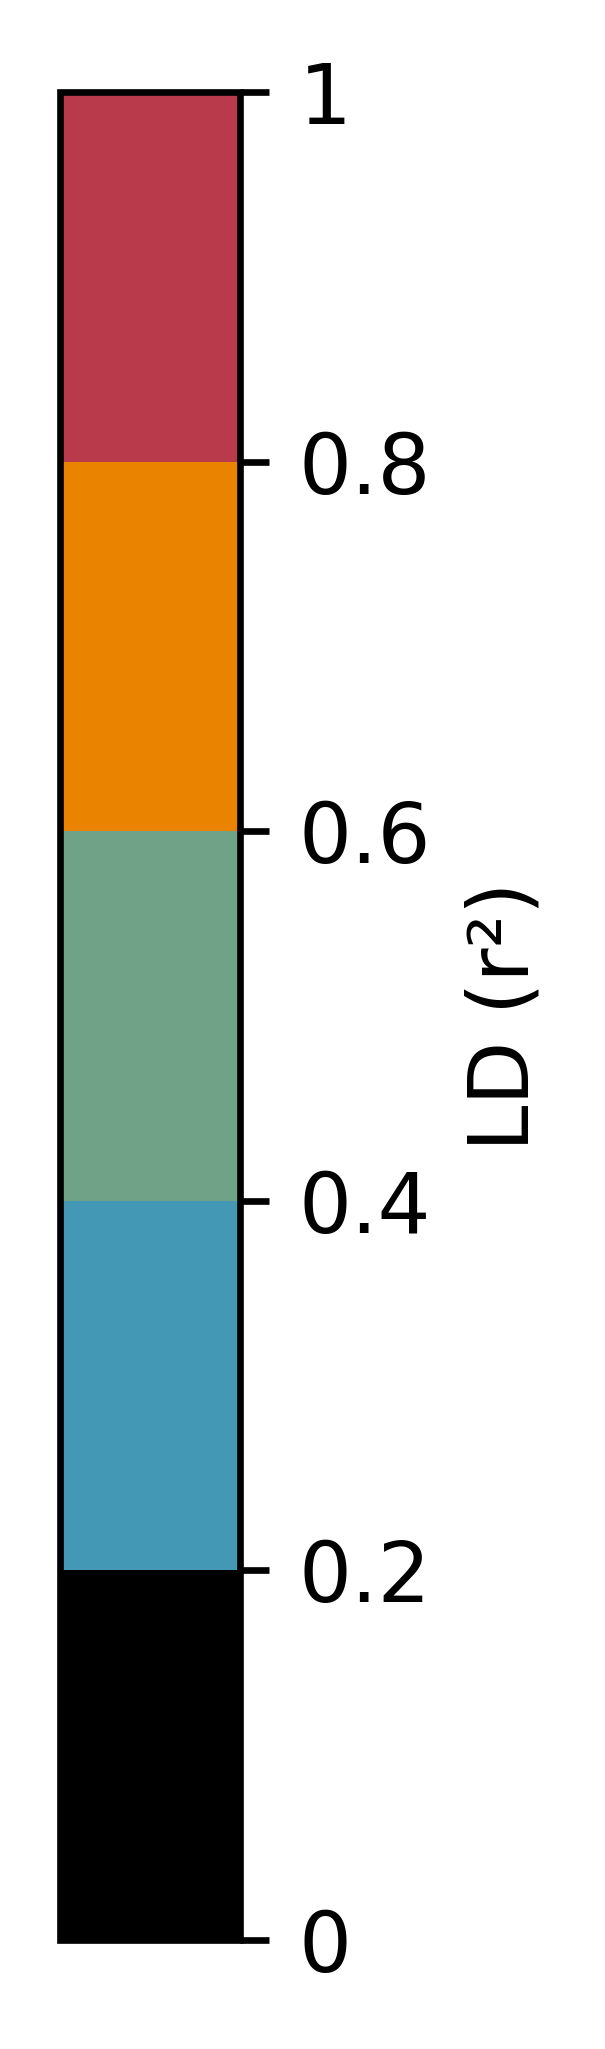

In [ ]:
# Create a custom colormap and normalization for the LD colorbar
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define color bins and colors
ld_bounds = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ld_colors = ['black', '#4298B5', '#6FA287', '#E98300', '#B83A4B']

ld_cmap = ListedColormap(ld_colors)
ld_norm = BoundaryNorm(ld_bounds, ld_cmap.N)

# Draw colorbar to illustrate LD color mapping
fig_cbar, ax_cbar = plt.subplots(figsize=(0.5, 4), dpi=600)
fig_cbar.subplots_adjust(left=0.3)  # leave space on left for upright labels

import numpy as np
import matplotlib as mpl

cb1 = mpl.colorbar.ColorbarBase(
    ax_cbar,
    cmap=ld_cmap,
    norm=ld_norm,
    boundaries=ld_bounds,
    ticks=ld_bounds,
    orientation='vertical'
)
cb1.set_label('LD (r²)')
cb1.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
plt.show()


In [ ]:
# --- Separate plot with legend for colocalized and lead variant ---

import matplotlib.lines as mlines

fig_leg, ax_leg = plt.subplots(figsize=(3, 2), dpi=400)
# For visual: add example points with labels to the legend only (single "dummy" points)
lead_marker = mlines.Line2D([], [], color=lead_color, marker='D', linestyle='None', markeredgecolor='black', markersize=10, label='Lead variant')
coloc_marker = mlines.Line2D([], [], color=coloc_color, marker='o', linestyle='None', markeredgecolor='black', markerfacecolor=coloc_color, markersize=10, label='Colocalized variant')
other_marker = mlines.Line2D([], [], color='lightgrey', marker='o', linestyle='None', markeredgecolor='k', markersize=8, label='Other variant')

# Only legend, no real plot
ax_leg.axis('off')
ax_leg.legend(
    handles=[lead_marker, coloc_marker, other_marker],
    loc='center',
    frameon=True,
    fontsize=11,
    markerscale=1.3,
    title="Variant types",
    title_fontsize=12
)
plt.show()

KeyboardInterrupt: 

2


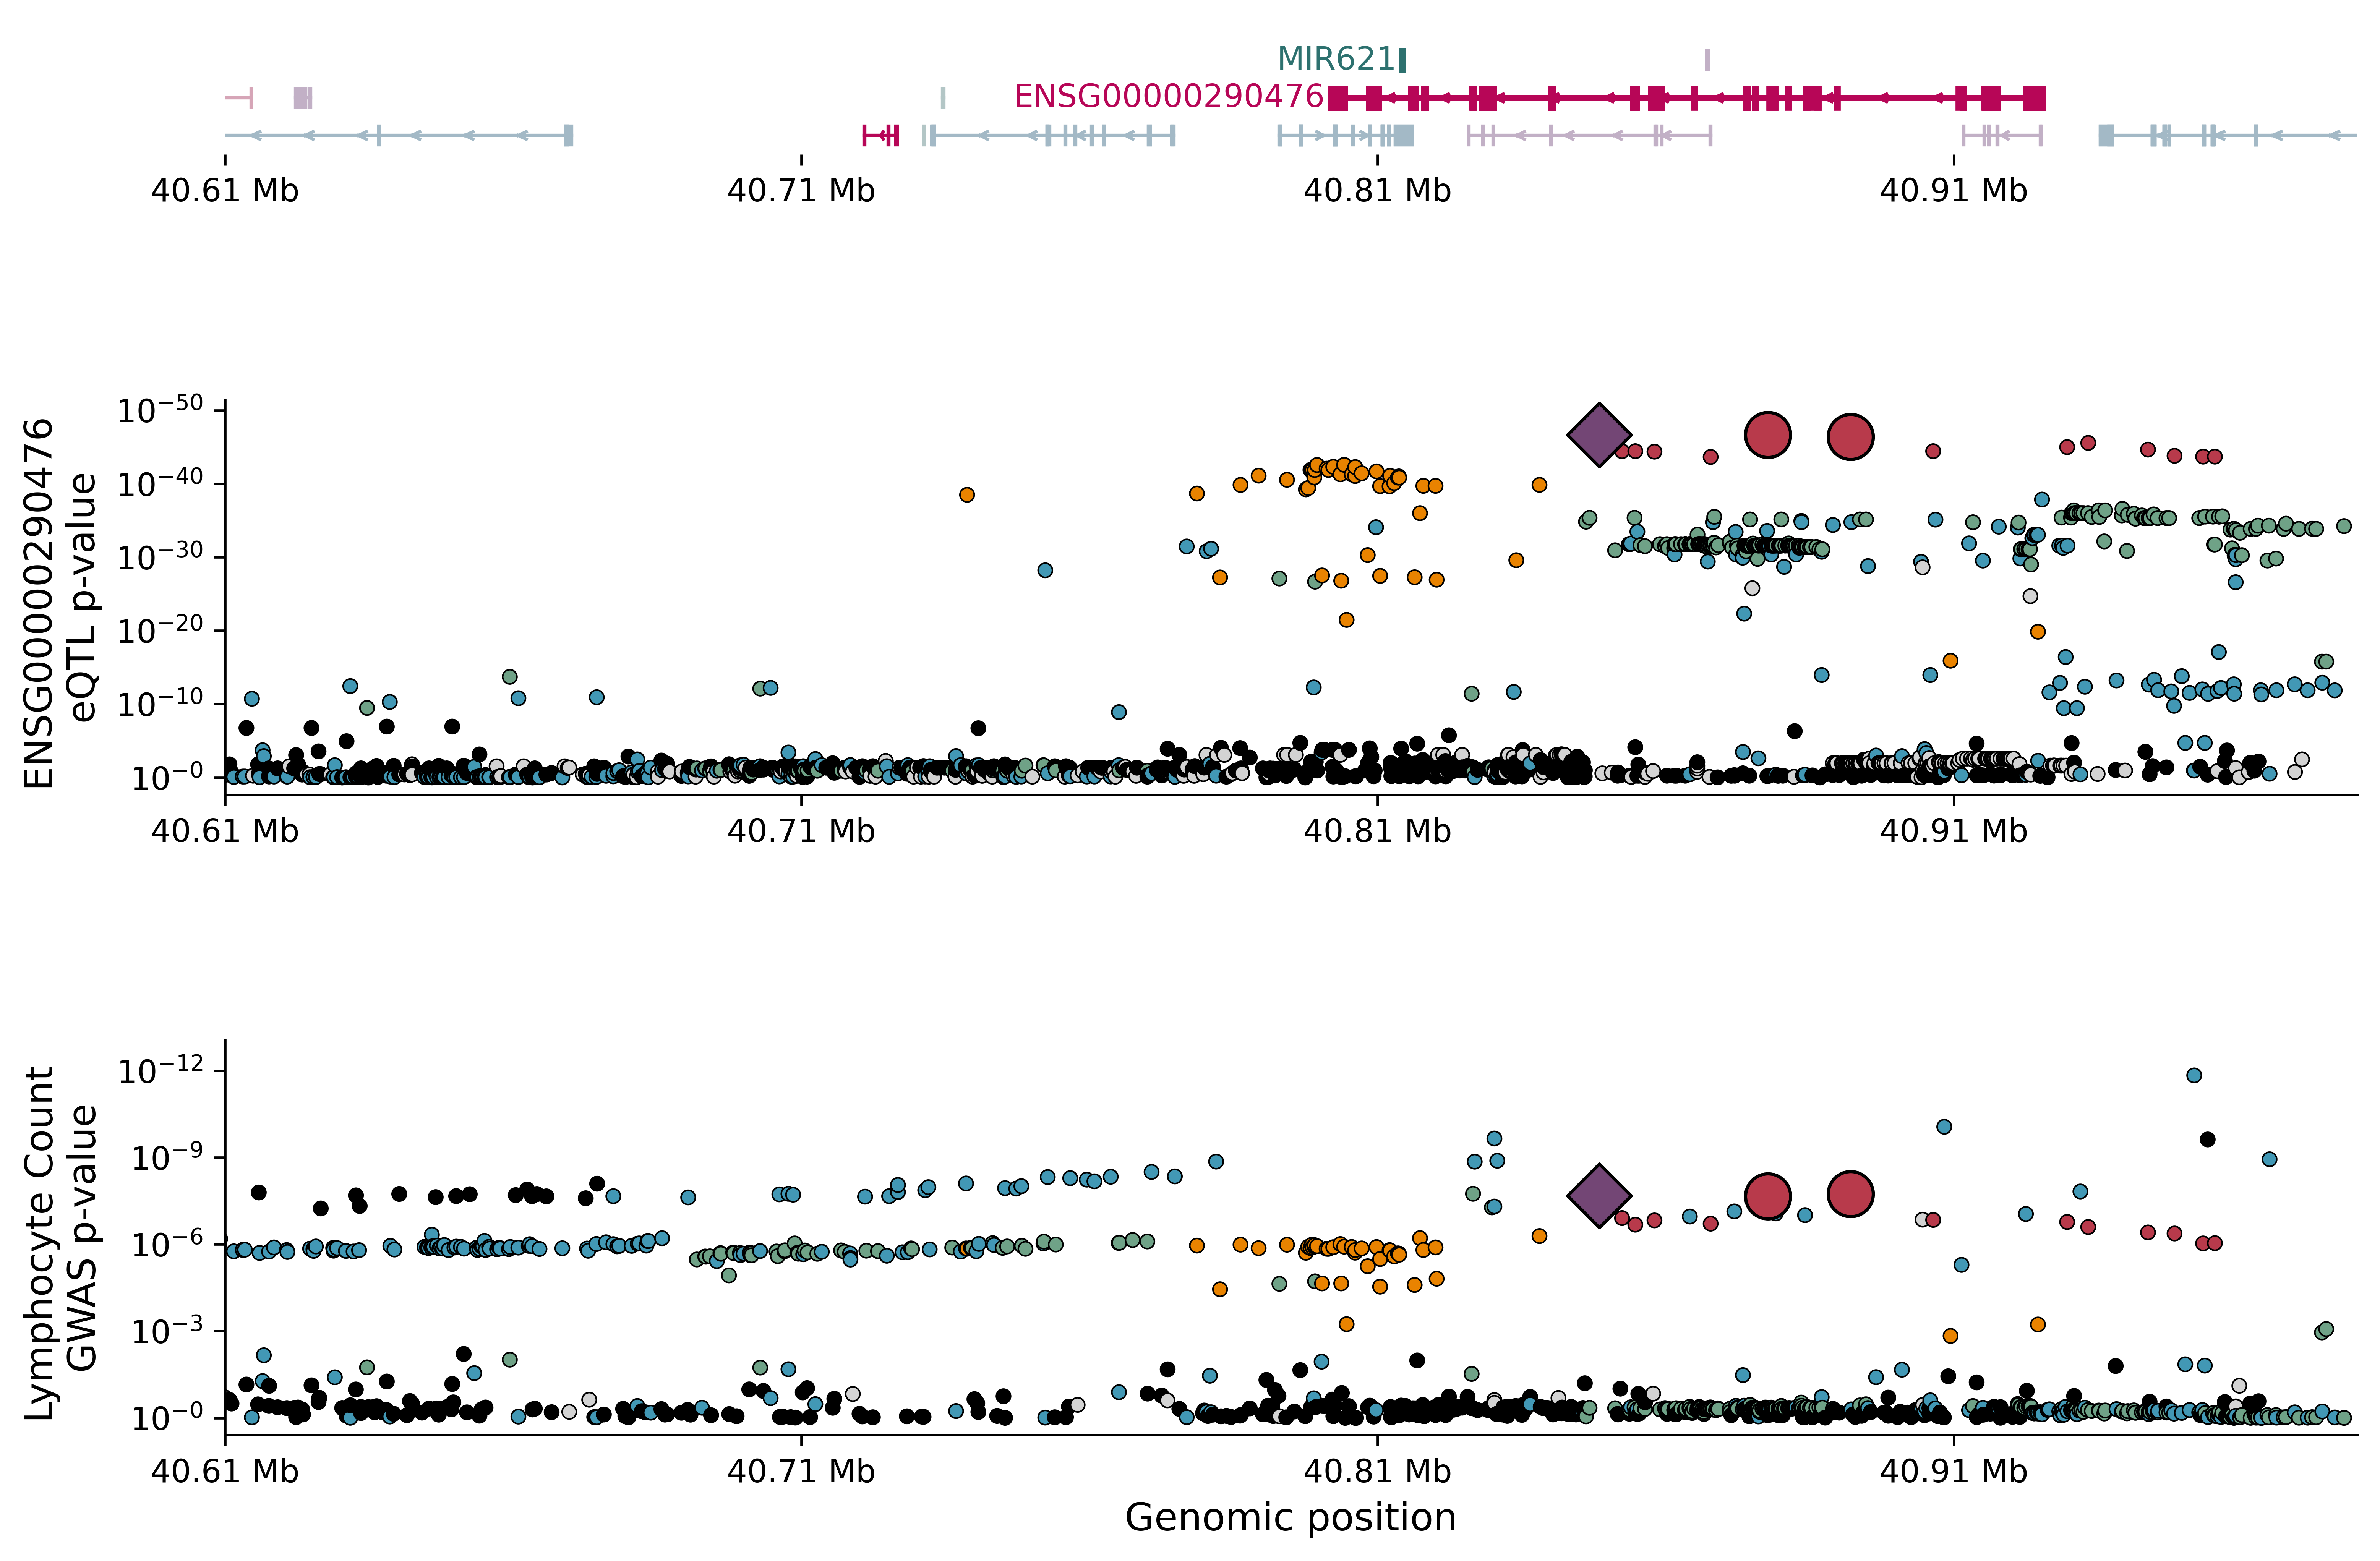

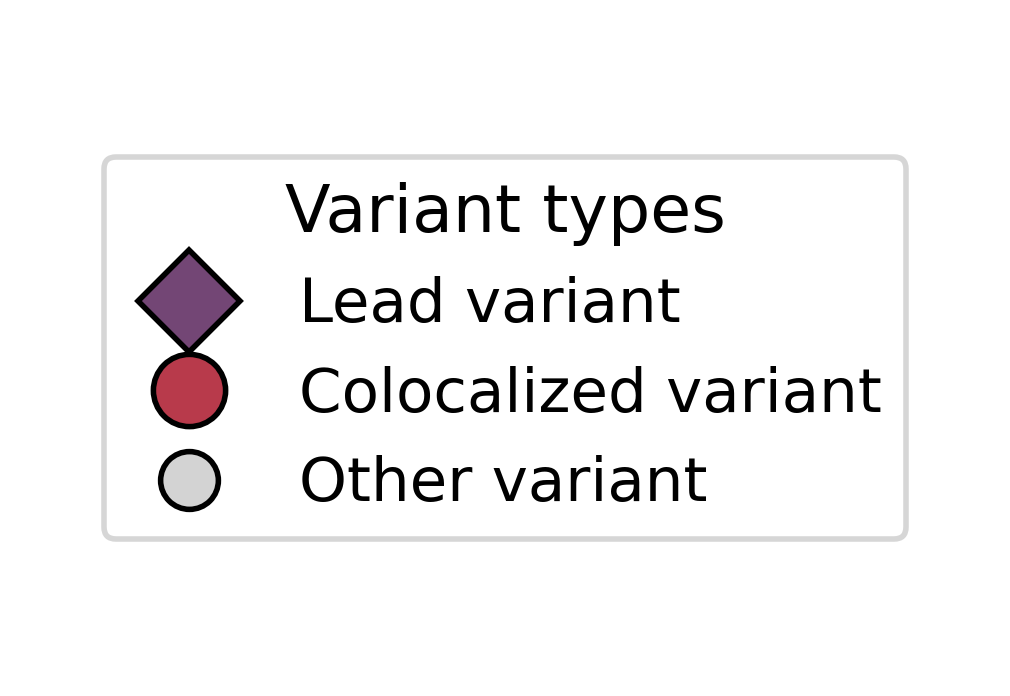

In [ ]:
# Simplified but preserves the output, no legends

from matplotlib import gridspec
import matplotlib.ticker as mticker

n_gene = len(example_gene_ids)
n_gwas = len(example_gwas_ids)
n_axes = n_gene + n_gwas + 1

# Set up figure and axes
height_ratios = [1] + [3] * (n_axes - 1)
fig = plt.figure(figsize=(10, 3 * (n_axes - 1) + 2), dpi=600)
gs = gridspec.GridSpec(n_axes, 1, height_ratios=height_ratios, hspace=0.8)
axs = []
for i in range(n_axes):
    if i == 0:
        ax = fig.add_subplot(gs[i, 0])
    else:
        ax = fig.add_subplot(gs[i, 0], sharex=axs[0])
    axs.append(ax)

# --- Top axis: gene/exon structure ---
gene_ax = axs[0]

gene_height = 0.6
gene_y_gap = 1.2
tracks_last_end, gene_indices = [], {}
gene_intervals = sorted(
    [{
        'start': row['Start'], 'end': row['End'],
        'gene_id': row['gene_id'], 'row': row
    } for _, row in genes_in_window.iterrows()],
    key=lambda x: x['start']
)

for gene in gene_intervals:
    gene_id, row = gene['gene_id'], gene['row']
    # Stack non-overlapping genes on separate rows
    for y_i, last_end in enumerate(tracks_last_end):
        if gene['start'] > last_end:
            break
    else:
        y_i = len(tracks_last_end)
        tracks_last_end.append(0)
    gene_y = y_i * gene_y_gap
    tracks_last_end[y_i] = gene['end']
    gene_indices[gene_id] = gene_y

    if gene_id == "ENSG00000290476.2":
        gene_name, gene_type_color, lw = "ENSG00000290476", gene_type_pal_greyed['new_lncRNA'], 2
    elif gene_id == "ENSG00000207652.1":
        gene_name, gene_type_color, lw = "MIR621", gene_type_pal_highlight['sRNA'], 2
    else:
        gene_name = row.get('gene_name', gene_id)
        gene_type = gencode_ids[gencode_ids['gene_id_v47'] == gene_id]['gene_type_grouped_highlight'].values[0]
        gene_type_color, lw = gene_type_pal_greyed[gene_type], 1

    gene_ax.plot([row['Start'], row['End']], [gene_y] * 2, lw=lw, color=gene_type_color, zorder=1)

    # Arrowheads for strand
    strand = row.get('Strand', row.get('strand', '+'))
    n_arrows = max(1, int((row['End'] - row['Start']) // 10000))
    if n_arrows > 0:
        arrow_spacing = (row['End'] - row['Start']) / (n_arrows + 1)
        arrow_head_len = arrow_spacing * 0.15
        for j in range(1, n_arrows + 1):
            if strand == "+":
                x = row['Start'] + j * arrow_spacing
                dx = -arrow_head_len
            else:
                x = row['End'] - j * arrow_spacing
                dx = arrow_head_len
            gene_ax.plot([x + dx, x], [gene_y - 0.2 * gene_height, gene_y], color=gene_type_color, lw=1, zorder=3)
            gene_ax.plot([x + dx, x], [gene_y + 0.2 * gene_height, gene_y], color=gene_type_color, lw=1, zorder=3)

    # Exons
    gene_exons = exons_in_window[exons_in_window['gene_id'] == gene_id]
    for _, exon in gene_exons.iterrows():
        gene_ax.add_patch(plt.Rectangle(
            (exon['Start'], gene_y - gene_height / 2),
            exon['End'] - exon['Start'], gene_height,
            edgecolor=gene_type_color, facecolor=gene_type_color, zorder=2,
            lw=lw
        ))

    # Highlighted gene names
    if gene_id in ["ENSG00000290476.2", "ENSG00000207652.1"]:
        x_label = row['End'] if strand == "+" else row['Start']
        gene_ax.text(x_label - 1000, gene_y, gene_name, va='center', ha='right', fontsize=10, color=gene_type_color)

gene_ax.set_ylim(-gene_height, len(tracks_last_end) * gene_y_gap)
gene_ax.set_yticks([])
gene_ax.set_ylabel("")
gene_ax.set_xlabel("")
for spine in gene_ax.spines.values():
    spine.set_visible(False)
gene_ax.set_xlim(window_xlim)
gene_ax.set_xticks([])  # Remove xticks for top axis

# --- Plot locuszooms for eQTL and GWAS ---

lead_color = '#734675'
coloc_color = '#B83A4B'  # distinct for coloc

ax_idx = 1

def scatter_variants(ax, block, pos_col, p_col, var_col, variant_highlight_set, lead_variant_id, ld_to_coloc, ld_cmap, norm):
    colors = block[var_col].map(ld_to_coloc)
    default_color = 'lightgrey'
    color_vals = [ld_cmap(norm(ld)) if not np.isnan(ld) else default_color for ld in colors]
    sc = ax.scatter(block[pos_col], -np.log10(block[p_col]), c=color_vals, alpha=1, s=20, edgecolor='k', lw=0.5)
    # CS variants (minus lead)
    cs_variants = set(variant_highlight_set) & set(block[var_col])
    cs_variants_no_lead = [v for v in cs_variants if v != lead_variant_id]
    if cs_variants_no_lead:
        cs_df = block[block[var_col].isin(cs_variants_no_lead)]
        cs_colors = [ld_cmap(norm(ld)) if not np.isnan(ld) else default_color for ld in cs_df[var_col].map(ld_to_coloc)]
        ax.scatter(cs_df[pos_col], -np.log10(cs_df[p_col]), c=cs_colors, alpha=1, s=200, edgecolor='black', lw=1)
    # Lead
    if lead_variant_id in set(block[var_col]):
        lead_row = block[block[var_col] == lead_variant_id]
        ax.scatter(lead_row[pos_col], -np.log10(lead_row[p_col]), c=lead_color, edgecolor='black', lw=1, s=200, marker='D', zorder=10)
    ax.set_ylabel("p-value")
    def pow10fmt(x, pos):
        return f"$10^{{-{int(x)}}}$" if x == int(x) else f"$10^{{-{x:.1f}}}$"
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True, nbins=6))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(pow10fmt))
    ax.set_xlim(window_xlim)
    return sc

# eQTL gene(s)
for gene_id in example_gene_ids:
    ax = axs[ax_idx]
    block = gene_nominal_associations_block[gene_nominal_associations_block['gene_id'] == gene_id].copy()
    scatter_variants(
        ax, block, pos_col='pos', p_col='pval_nominal', var_col='variant_id',
        variant_highlight_set=variant_highlight_set, lead_variant_id=lead_variant_id,
        ld_to_coloc=ld_to_coloc, ld_cmap=ld_cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1)
    )
    #ax.set_title(f"locuszoom: {gene_id}")
    ax.set_ylabel("ENSG00000290476 \neQTL p-value", fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.05)

    # No legends
    sns.despine(ax=ax)
    # Only remove x tick labels for all but the bottom axis; keep on bottom
    ax.set_xticklabels([])  # remove xticklabels from all but bottom axis
    ax.set_xlabel('')
    ax_idx += 1

# GWAS(s)
for gwas_id in example_gwas_ids:
    ax = axs[ax_idx]
    block = gwas_nominal_associations_block[gwas_nominal_associations_block['gwas_id'] == gwas_id].copy()
    var_col = "panel_variant_id" if "panel_variant_id" in block.columns else "variant_id"
    block['pos'] = block[var_col].str.split('_').str[1].astype(int)
    scatter_variants(
        ax, block, pos_col='pos', p_col='pvalue', var_col=var_col,
        variant_highlight_set=variant_highlight_set, lead_variant_id=lead_variant_id,
        ld_to_coloc=ld_to_coloc, ld_cmap=ld_cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1)
    )
    #ax.set_title(f"locuszoom: gwas {gwas_id}")
    ax.set_ylabel("Lymphocyte Count \nGWAS p-value", fontsize=12)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.05)
    # No legends
    sns.despine(ax=ax)
    # For all except the very bottom axis, remove xticklabels and xlabel
    if ax_idx < n_axes - 1:
        ax.set_xticklabels([])  # remove xticklabels from all but bottom axis
        ax.set_xlabel('')
    else:
        # For the bottom-most axis, enable xticks and label
        ax.set_xlabel("Genomic position", fontsize=12)
        # Set x ticks to be every 100 kb in window_xlim
        xtick_step = 100_000
        xticks = np.arange(window_xlim[0], window_xlim[1]+1, xtick_step)
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{x/1_000_000:.2f} Mb" for x in xticks])
    ax_idx += 1

#plt.tight_layout()
plt.show()


### locus compare

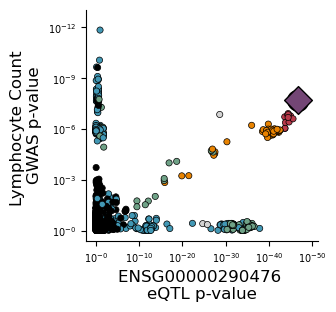

In [239]:
import matplotlib.lines as mlines

# 1 row per gene, 1 column per gwas
n_rows = len(example_gene_ids)
n_cols = len(example_gwas_ids)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows), squeeze=False)

# Marker and color setup per previous pane
lead_color = '#734675'
coloc_color = '#B83A4B'
default_color = 'lightgrey'

for i, gene_id in enumerate(example_gene_ids):
    gene_block = gene_nominal_associations_block[
        gene_nominal_associations_block['gene_id'] == gene_id
    ].copy()
    gene_block = gene_block.set_index('variant_id')

    for j, gwas_id in enumerate(example_gwas_ids):
        ax = axs[i, j]
        gwas_block = gwas_nominal_associations_block[
            gwas_nominal_associations_block['gwas_id'] == gwas_id
        ].copy()

        # Determine variant ID field
        if "panel_variant_id" in gwas_block.columns:
            gwas_block['panel_variant_id'] = gwas_block['panel_variant_id'].astype(str)
            gwas_block = gwas_block.set_index('panel_variant_id')
            gene_index_set = set(gene_block.index)
            gwas_index_set = set(gwas_block.index)
            variant_ids = list(gene_index_set & gwas_index_set)
            gene_vals = gene_block.loc[variant_ids, 'pval_nominal']
            gwas_vals = gwas_block.loc[variant_ids, 'pvalue']
            plot_index = variant_ids

        else:
            gwas_block = gwas_block.set_index('variant_id')
            gene_index_set = set(gene_block.index)
            gwas_index_set = set(gwas_block.index)
            variant_ids = list(gene_index_set & gwas_index_set)
            gene_vals = gene_block.loc[variant_ids, 'pval_nominal']
            gwas_vals = gwas_block.loc[variant_ids, 'pvalue']
            plot_index = variant_ids

        # -- Build arrays for scatter based on variant class
        x = -np.log10(gene_vals)
        y = -np.log10(gwas_vals)

        # Find lead variant and coloc variants (excluding lead)
        lead_marker_idx = [k for k, vid in enumerate(plot_index) if vid == lead_variant_id]
        coloc_idx = [k for k, vid in enumerate(plot_index) if (vid in variant_highlight_set and vid != lead_variant_id)]

        # Indices of "other" variants
        highlight_set = {lead_variant_id} | (variant_highlight_set if isinstance(variant_highlight_set, set) else set(variant_highlight_set))
        other_idx = [k for k, vid in enumerate(plot_index) if vid not in highlight_set]

        # ld colors
        cs_colors = [ld_cmap(norm(ld)) if not np.isnan(ld) else default_color for ld in pd.Series(variant_ids).map(ld_to_coloc)]

        # -- Plot other variants
        if other_idx:
            ax.scatter(
                x.iloc[other_idx], y.iloc[other_idx],
                c=pd.Series(cs_colors).iloc[other_idx], marker='o', edgecolor='k', s=20, lw=0.5, alpha=1
            )
        # -- Plot coloc variants (non-lead) using color+big circle
        if coloc_idx:
            ax.scatter(
                x.iloc[coloc_idx], y.iloc[coloc_idx],
                c=coloc_color, marker='o', edgecolor='black',
                s=200, lw=1, alpha=1, zorder=10
            )
        # -- Plot lead variant (diamond, colored, black edge, largest)
        if lead_marker_idx:
            ax.scatter(
                x.iloc[lead_marker_idx], y.iloc[lead_marker_idx],
                c=lead_color, marker='D', edgecolor='black',
                s=200, lw=1, alpha=1, zorder=11
            )

        # Axes labeling and formatting
        if i == n_rows - 1:
            ax.set_xlabel("-log10(gene p-value)")
        if j == 0:
            ax.set_ylabel("-log10(GWAS p-value)")

        def pow10fmt(x, pos):
            return f"$10^{{-{int(x)}}}$" if x == int(x) else f"$10^{{-{x:.1f}}}$"
        ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True, nbins=6))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(pow10fmt))
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True, nbins=6))
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(pow10fmt))
        # Set the tick label fontsize
        ax.tick_params(axis='both', labelsize=7)

        #ax.set_title(f"Gene: {gene_id}, GWAS: {gwas_id}")

        sns.despine(ax=ax)
        ax.set_xlabel("ENSG00000290476 \neQTL p-value", fontsize=12)
        ax.set_ylabel("Lymphocyte Count \nGWAS p-value", fontsize=12)
        ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]*1.05)
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.05)

plt.show()
